In [19]:
# Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
path_to_csv = r'../data/user_behavior.csv' # path to dataset

In [21]:
df = pd.read_csv(path_to_csv) # loading dataset into pandas dataframe

In [22]:
# analyzing dataset and cleaning

df.shape                   # Check shape of the dataset
df.info()                  # Data types and non-null counts
df.isnull().sum()          # Nulls per column
df[df.isnull().any(axis=1)]  # See rows with any missing values
df.duplicated().sum()      # Number of duplicate rows
df = df.drop_duplicates()  # Remove duplicates
df['churned'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 1000 non-null   int64  
 1   account_age_days        1000 non-null   int64  
 2   total_hours_watched     1000 non-null   int64  
 3   num_genres_watched      1000 non-null   int64  
 4   avg_watch_time_per_day  1000 non-null   float64
 5   num_devices             1000 non-null   int64  
 6   support_tickets_opened  1000 non-null   int64  
 7   churned                 1000 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 62.6 KB


churned
0    0.503
1    0.497
Name: proportion, dtype: float64

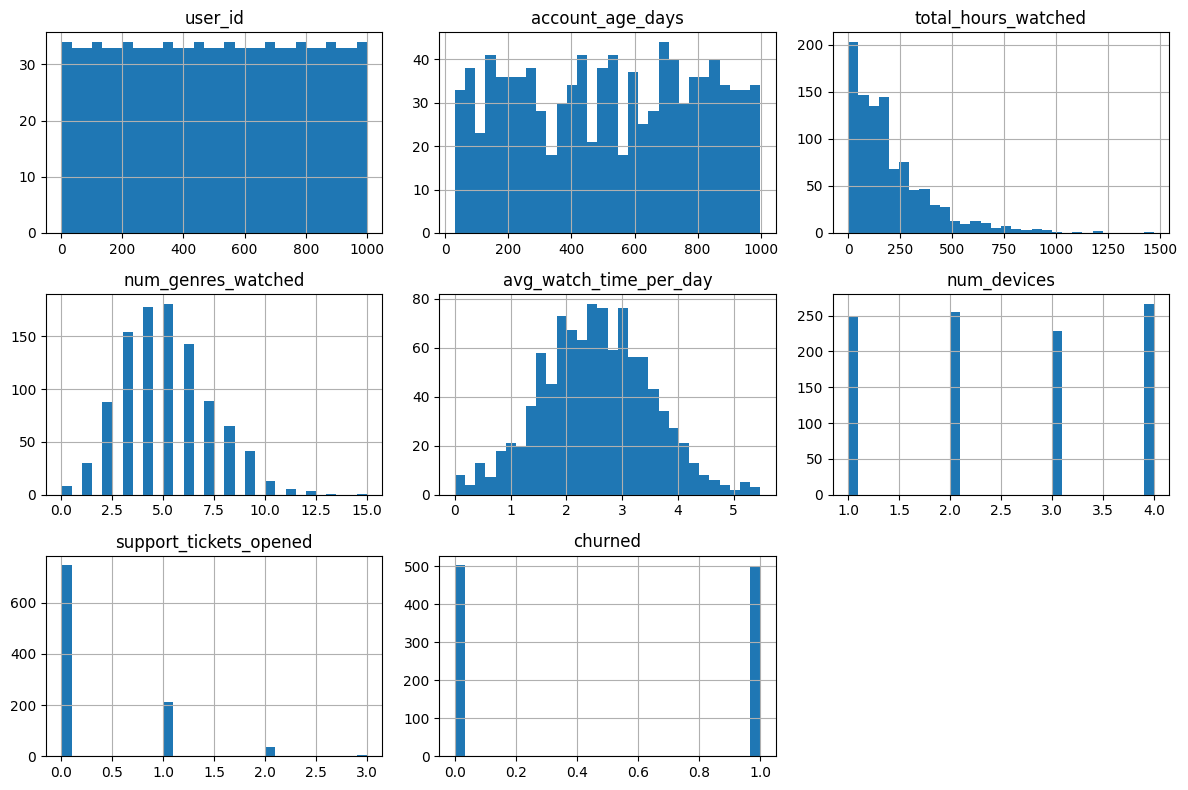

In [23]:
# numerical columns
df.hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

In [ ]:
                        # My Theories.
# ----------------------------------------------------------------------
# Users with older accounts and declining engagement — measured by both daily watch time and total hours watched — appear more likely to churn.
# Contrary to expectation, users who open more support tickets are less likely to churn — possibly indicating that users who seek help are more 
# engaged or that support effectively resolves churn-risk issues.
# It appears there’s no strong correlation between churn and number of devices — unless maybe one device is the main one and it’s in another household.
# A decrease in average watch time correlates with fewer genres watched — which aligns with the earlier insight that older users are less engaged and 
# more likely to churn.
# Users with older accounts tend to explore fewer genres and watch less on average per day — all indicators of declining engagement, which appears to 
# strongly correlate with churn risk.

In [31]:
df['engagement_level'] = pd.cut(df['avg_watch_time_per_day'], bins=[0, 1, 2, 3, 10], labels=["Low", "Med", "High", "Very High"])
print(df)
df.groupby('engagement_level', observed=True)['churned'].mean().sort_index()

     user_id  account_age_days  total_hours_watched  num_genres_watched  \
0          1               132                    2                   7   
1          2               465                   15                   5   
2          3               890                  235                   4   
3          4               300                  152                   4   
4          5               136                  277                   6   
..       ...               ...                  ...                 ...   
995      996               639                   43                   4   
996      997               134                   36                   4   
997      998               128                  192                   4   
998      999               540                  148                   4   
999     1000               414                  221                   6   

     avg_watch_time_per_day  num_devices  support_tickets_opened  churned  \
0                  2.2

engagement_level
Low          0.547170
Med          0.543568
High         0.542328
Very High    0.408669
Name: churned, dtype: float64